<a href="https://colab.research.google.com/github/abhinavgairola/Anomaly_Detection_OTC_Market/blob/main/Scripts/EDA_Machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This peace of code uses Logistic regression and Sklearns GridSearchCV, pipeline capabilities to train and tweak XgBoost and Logistic regression classifier. The aim is to understand which features contributes towards a potential pump and dump scheme--stock sentiments are a serious driver. However in a portfolio of stocks which stocks are pumped the most can also be understood.

In [1]:


def pipeline_creator(model):
  """
  Pipeline creator method
  """

  pipe = Pipeline([('scaler', StandardScaler()), ('classifier',model)])

  return pipe

def XgboostClassifier(X_test,y_test,X_train,y_train):
  """
  Method to train a basic Xgboost classifier-- essentially a wrapper for my own purpose around the scikit learn methods
  This is without any optimization
  """
  model = xgboost.sklearn.XGBClassifier()

  pipe = pipeline_creator(model)#Pipeline([('scaler', StandardScaler()), ('classifier',model)])

  pipe.fit(X_train,y_train)

  y_pred = pipe.predict(X_test)

  probabilities = pipe.predict_proba(X_test) ## Get prediction probabilities to be used in roc_curve methods

  accuracy = accuracy_score(y_test, y_pred)

  print("Accuracy{}".format (accuracy * 100.0))

  tpr_1, fpr_1, threshold_1 = roc_curve(y_test, probabilities[:,0]) ## Positivety and False positivity rate for class 0

  fpr_2, tpr_2, threshold_2 = roc_curve(y_test, probabilities[:,1]) ## Positivety and False positivity rate for class 1

  precision, recall, threshold = precision_recall_curve(y_test, probabilities[:,0])




  return [tpr_1,fpr_1,fpr_2,tpr_2,y_pred,model,pipe, precision, recall]












In [2]:
#https://xgboost.readthedocs.io/en/latest/parameter.html
## Optimizing the model using GridSearchCV


def predict_fit( model,folds, params_,metric, X_train, y_train, X_test, y_test):

  """
  This method use gridsearchcv to optimize around the supplied parameters, fit, predict, compute accuracy, precision, recall and roc curve

  """




  grid = GridSearchCV(model, params_, cv=folds, scoring=metric)

  grid.fit(X_train, y_train)

  if ((type(model)).__name__) == 'LogisticRegression':
    feature_importance = grid.best_estimator_.coef_
  
  elif ((type(model)).__name__) != 'LogisticRegression':
    feature_importance = grid.best_estimator_.feature_importances_

  y_pred = grid.best_estimator_.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)

  probabilities = grid.predict_proba(X_test)## Class prediction probabilities.

  tpr_1, fpr_1, threshold_1 = roc_curve(y_test, probabilities[:,0]) ## Positivety and False positivity rate for class 0

  fpr_2, tpr_2, threshold_2 = roc_curve(y_test, probabilities[:,1]) ## Positivety and False positivity rate for class 1

  precision, recall, threshold = precision_recall_curve(y_test, probabilities[:,0])

  return {'tpr_1':tpr_1,'fpr_1':fpr_1,'fpr_2':fpr_2,'tpr_2':tpr_2,'predictions':y_pred,'model':grid.best_estimator_,'accuracy':accuracy, 'precision':precision, 'recall':recall,'feature_importance':feature_importance}


#params = {'learning_rate':[0.1,0.2,0.3],'max_depth':[5,6,7]} ## I am optimizing the XgBoost using the maximum depth and the learning rate. Hyper parameter tuning is an art.

#model = xgboost.sklearn.XGBClassifier()

#Output = predict_fit(model,6,params,'recall',X_smote,y_smote,X_test,y_test)
## Pipeline is erroring out for the time being it is fine to use GridSearchCV with XGBoost.
#pipe = pipeline_creator(model)
#grid = search_params(pipe, params, 6, 'precision')
#grid
#grid.fit(X_train,y_train)
#acc = predict(grid,X_train,y_train, X_test, y_test)
#print("Accuracry is {}".format(acc))
#parameter_tuning(pipe,params,6,'precision',X_test,y_test,X_train,y_train)

In [3]:
!pip install shap

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import xgboost## Just for checking the help on xbhoost later on
#from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
## pipeline to combine normalizing and model fitting at once
from sklearn.pipeline import Pipeline
## for model optimization
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, precision_recall_curve,average_precision_score, auc

In [6]:
import shap

In [7]:
import csv
from pycaret.classification import *
import math
import pandas as pd
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
data = {}
with open('/content/drive/MyDrive/OTCMKT/Final_data.csv') as f:
  csv_file = csv.DictReader(f)
  for idx,row in enumerate(csv_file):
    data[idx]=(dict(row))  

In [8]:
df = pd.DataFrame(data)

In [9]:
df=df.reset_index()

In [10]:

df = df.T
columns = df.loc['index',:]
df = df.drop('index',axis=0)
df = df.rename(columns=columns)

In [11]:
df = df.set_index('Date')


In [12]:
df = df.replace('', '0')


In [13]:
columns = list(df.columns)

In [14]:
columns.remove('Ticker_name')

In [15]:
columns

['Indicator', 'Price', 'Sentiment_Score', 'Tweet_counts', 'Volume']

In [16]:
df[columns]=df[columns].astype(float)

In [17]:
columns.remove('Indicator')
columns.remove('Price')

##Dataset is not *normalized*

In [18]:
from sklearn import preprocessing
print(columns)
x = df[columns].values 
Standard_scaler = preprocessing.StandardScaler()
x_scaled = Standard_scaler.fit_transform(x)
df_new = pd.DataFrame(x_scaled)
df_new.columns = columns

['Sentiment_Score', 'Tweet_counts', 'Volume']


In [19]:
df_new['Indicator'] = list(df.Indicator.values)
df_new['Price'] = list(df.Price.apply(lambda x: math.log1p(x) ).values)
df_new['Tickers'] = list(df.Ticker_name.values)
df_new = df_new.set_index(df.index)

In [20]:
df_new

,Sentiment_Score,Tweet_counts,Volume,Indicator,Price,Tickers
Date,,,,,,
2016-09-16,0.432992,-0.289043,-0.520014,0.0,0.137597,RGBP
2016-09-20,2.464075,1.063349,-0.516444,0.0,0.130438,RGBP
2016-09-21,-0.002017,-0.221634,-0.521036,0.0,0.117961,RGBP
2016-09-22,-0.711980,-0.107881,-0.518695,0.0,0.128613,RGBP
2016-09-29,-0.387962,-0.267978,-0.521649,0.0,0.119457,RGBP
...,...,...,...,...,...,...
2016-05-24,0.293547,0.241802,-0.522189,0.0,0.073111,PRHL
2016-05-27,-0.652031,0.532504,-0.522661,0.0,0.063092,PRHL
2016-05-31,0.373833,0.671534,-0.517209,0.0,0.070691,PRHL


In [21]:
columns = list(df_new.columns)
columns.remove('Tickers')

In [22]:
columns

['Sentiment_Score', 'Tweet_counts', 'Volume', 'Indicator', 'Price']

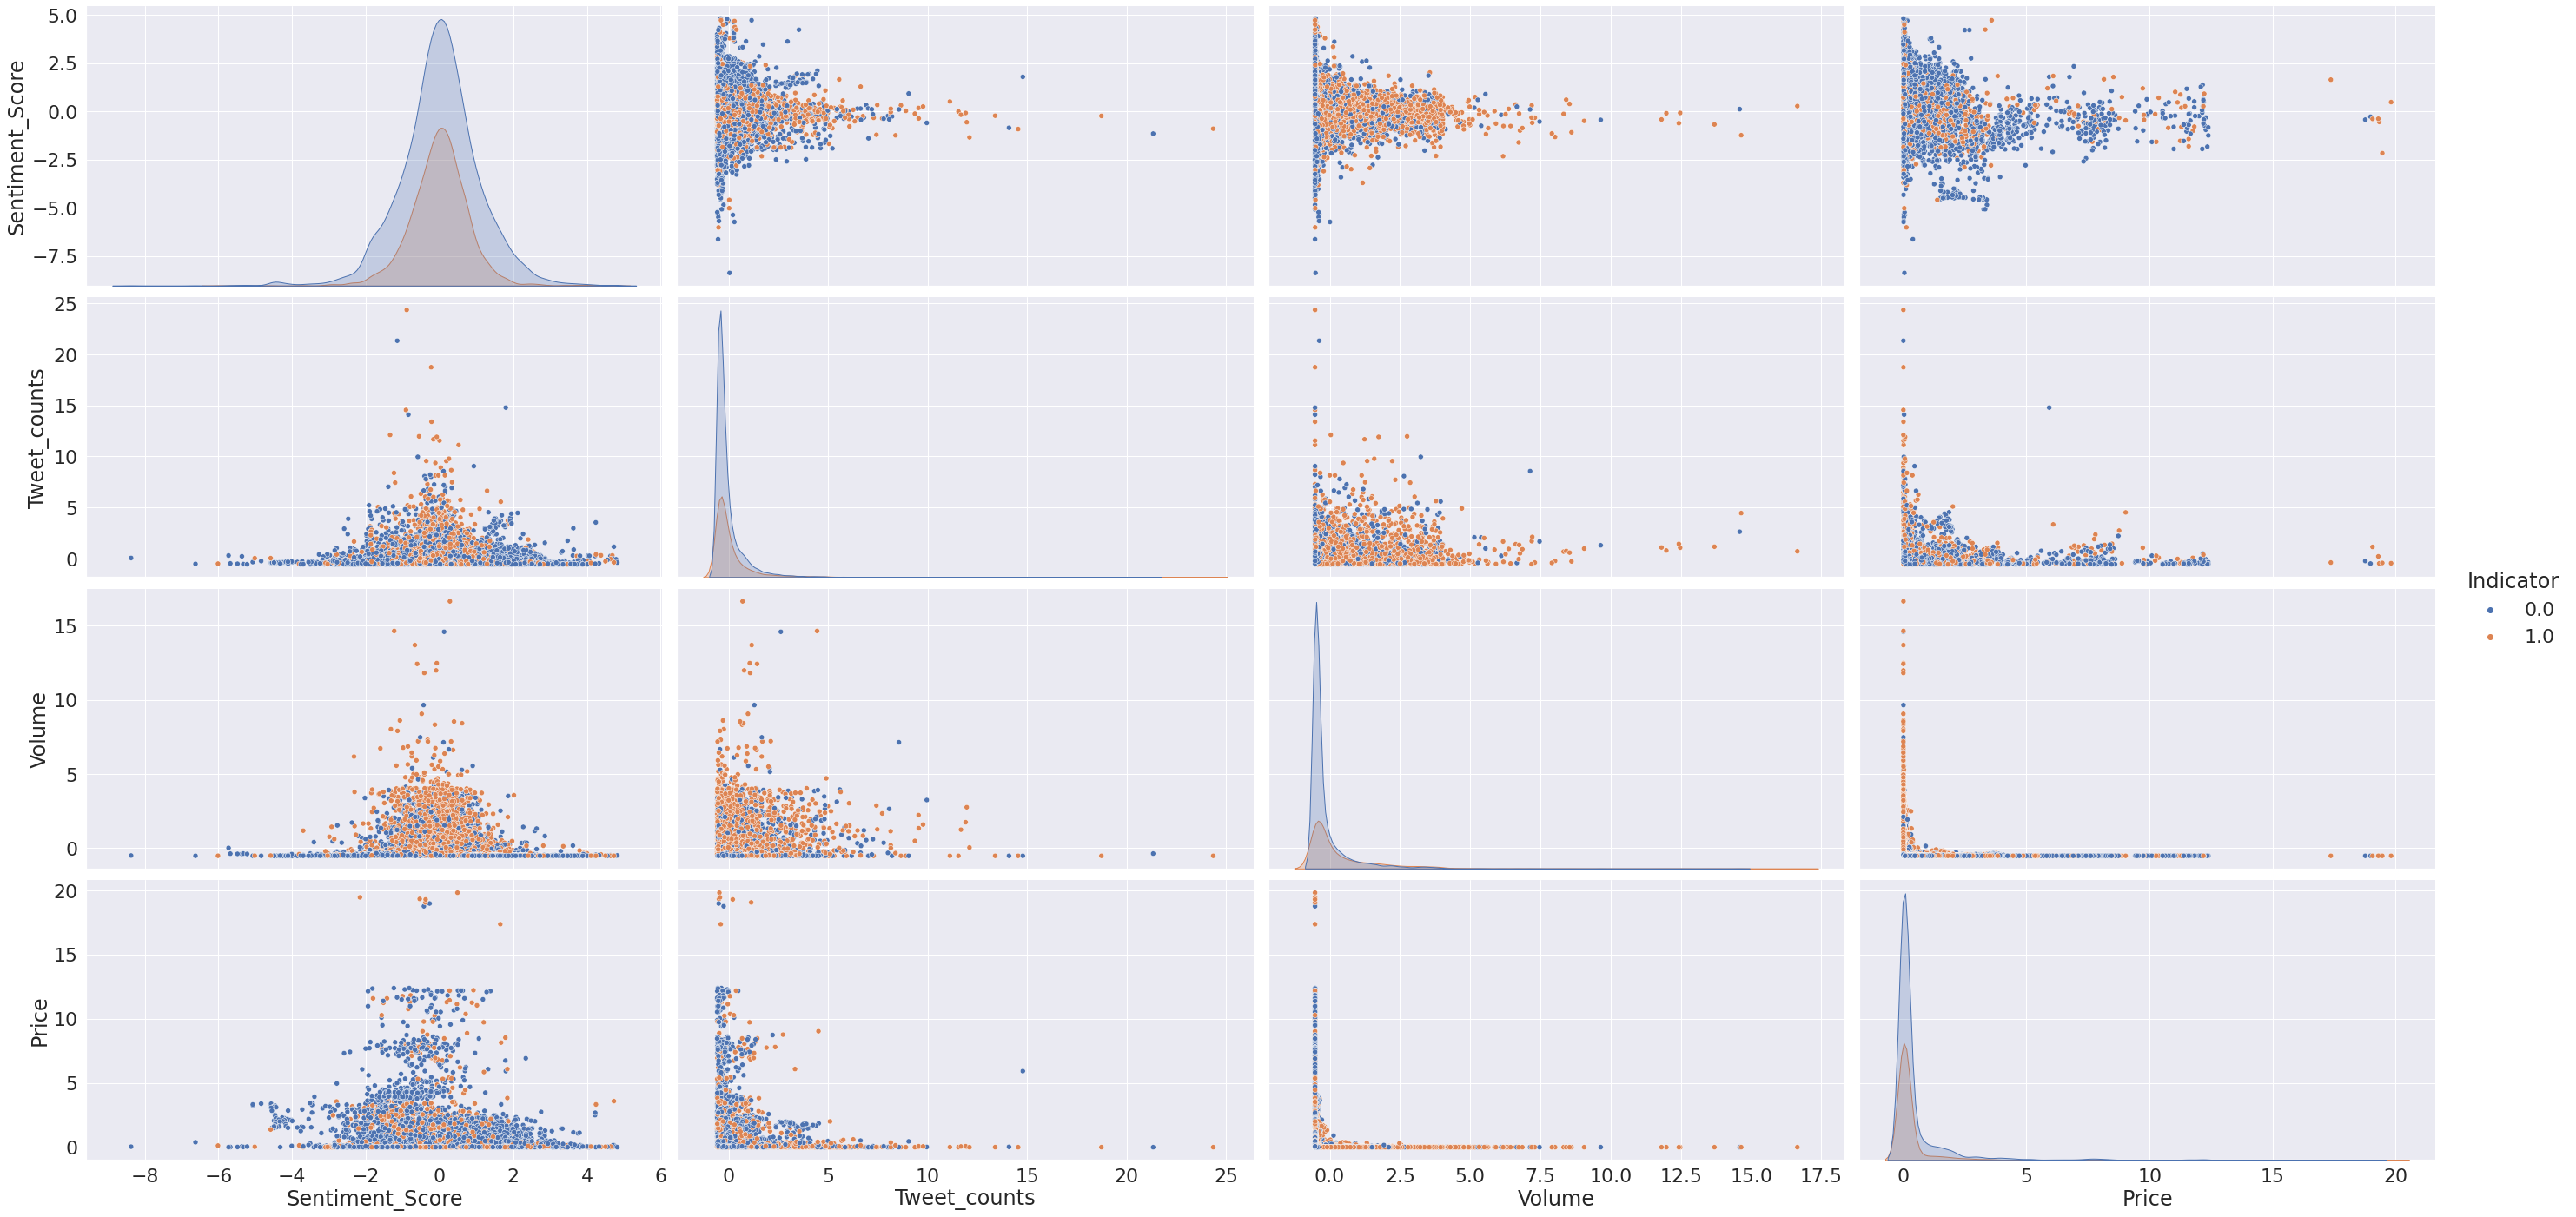

In [23]:
sns.set(font_scale = 2)
sns.pairplot(df_new[columns], hue='Indicator',height=5, 
    aspect=2)


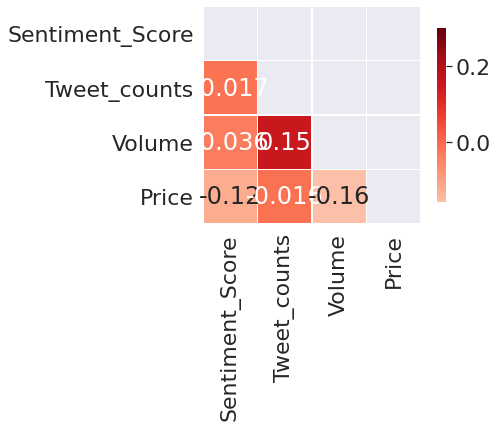

In [24]:
corr = df_new.drop('Indicator',axis=1).corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap='Reds', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, annot=True)

## No collinearity is seen

## Some relationship between the numerical and categorical variables can be check using the catplot or the box and whisker plots or the violin plot. I will use the later. 

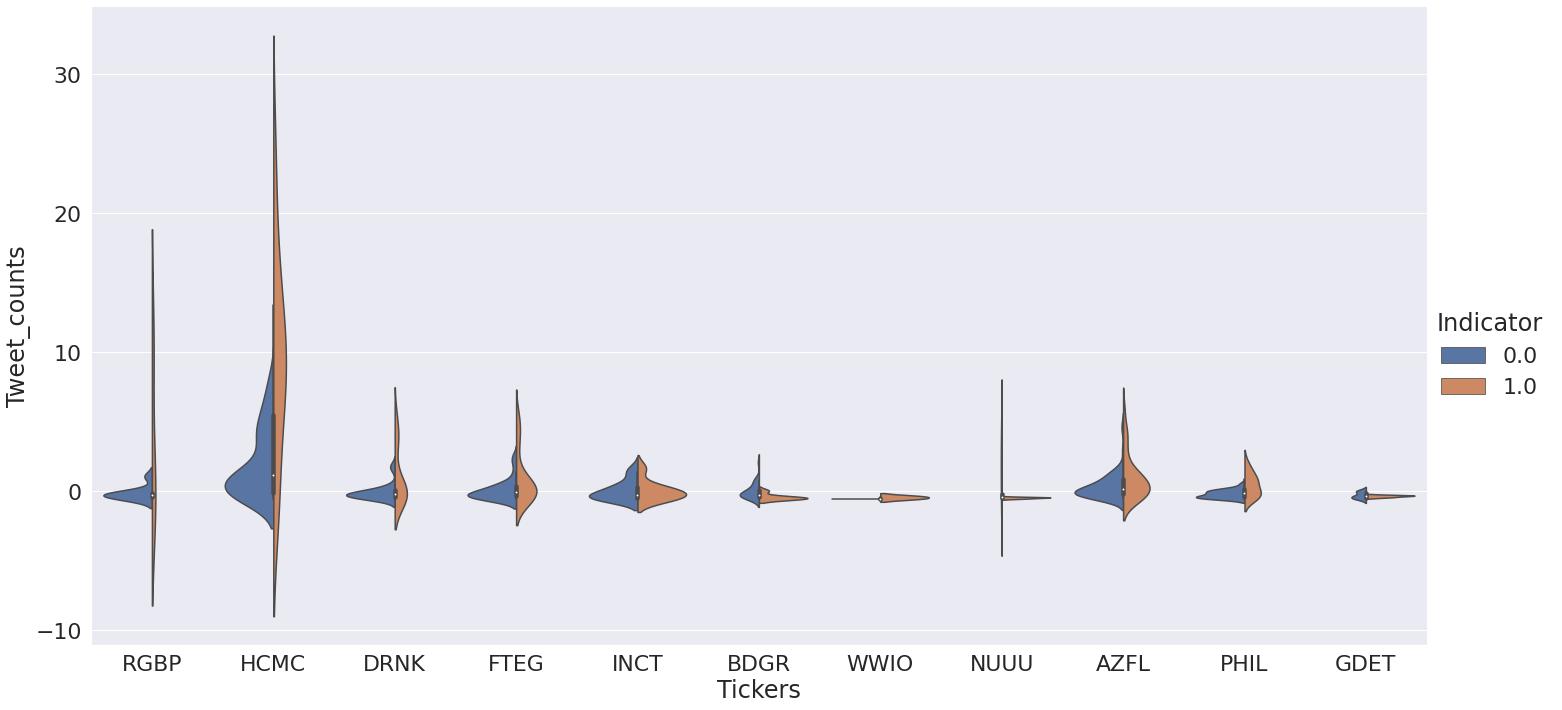

In [25]:

sns.catplot(
    data=df_new[0:500],
    x='Tickers',
    y='Tweet_counts',
    hue='Indicator',
    kind='violin',split=True,
    height=10,
    aspect=2)


## Tweet counts jumps to a higher number as the indicator switches to 1 from 0 for different tickers (in the case of the first 11 tickers in the dataframe). The reason can be a lot of people suddenly start to talk about the stocks owing to a surge in the price.

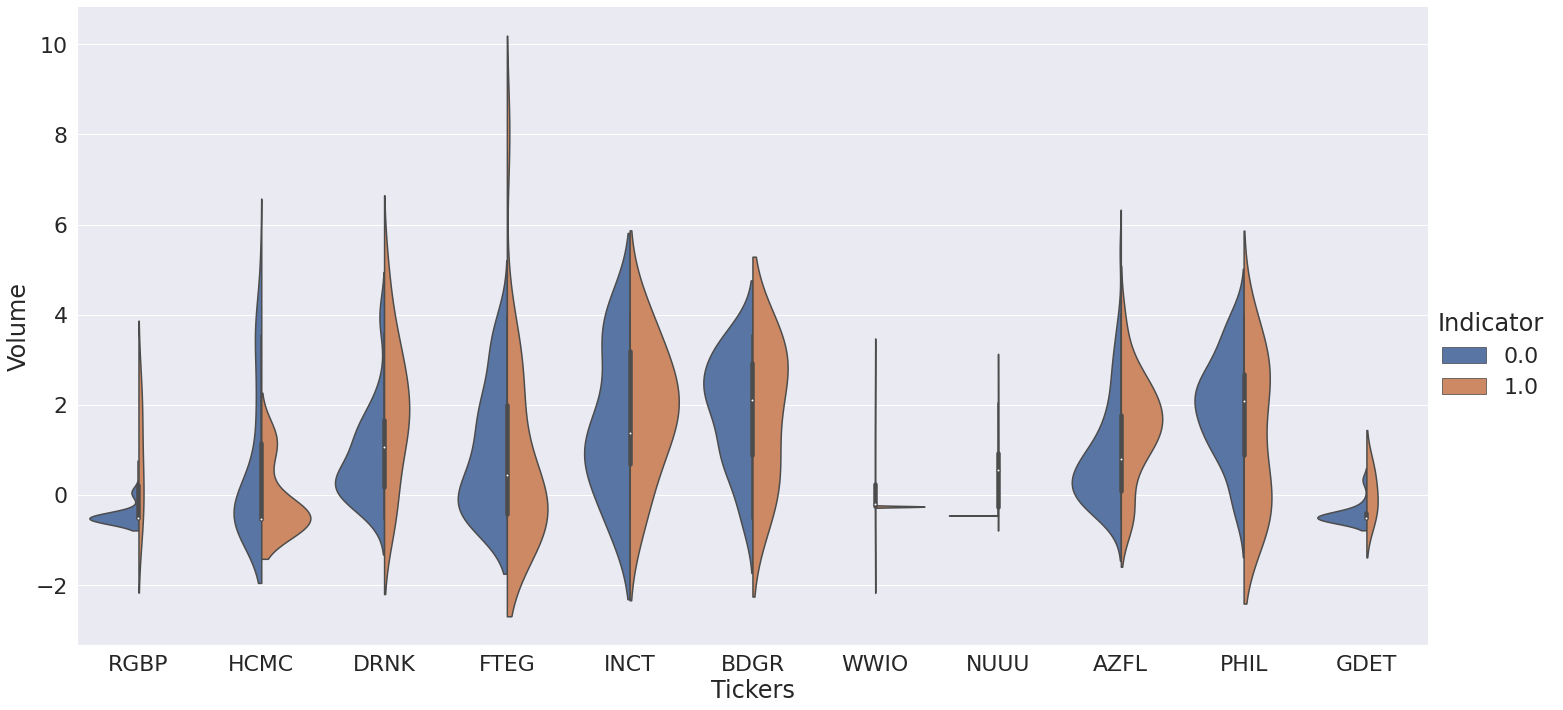

In [26]:
sns.catplot(
    data=df_new[0:500],
    x='Tickers',
    y='Volume',
    hue='Indicator',
    kind='violin',split=True,
    height=10,
    aspect=2)

## The traded volume increases (in the case of the first 4 tickers in the dataframe) too whenever the tweet counts jumps except in the case of the ticker 'HCMC'

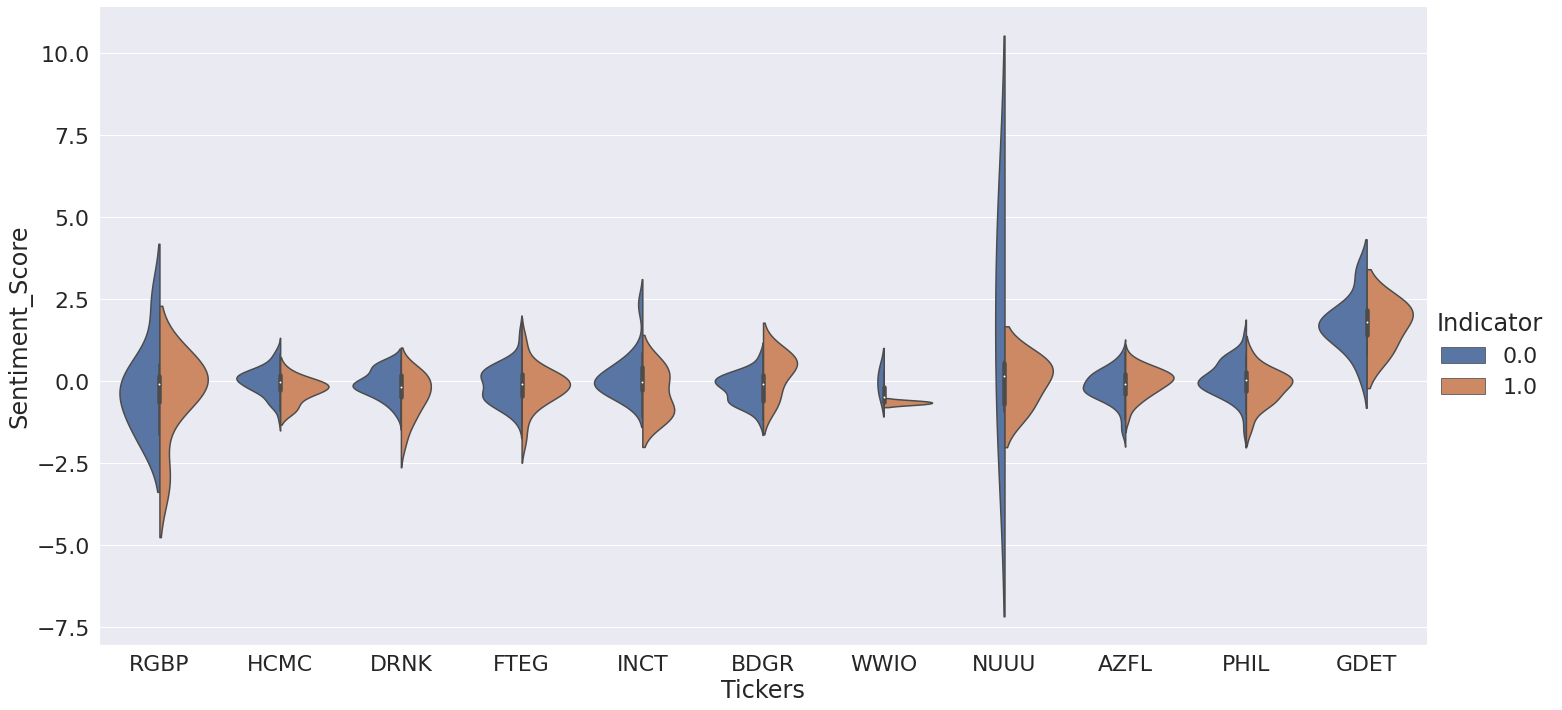

In [27]:
sns.catplot(
    data=df_new[0:500],
    x='Tickers',
    y='Sentiment_Score',
    hue='Indicator',
    kind='violin',split=True,
    height=10,
    aspect=2)

## It seems like (at least after looking at the sentiment scores of the first 11 tickers in the dataframe) that the sentiment score is higher when everything is normal about a particular stock. This makes sense as the pumper may try to create positive sentiments before the pump and dump scheme begins.

In [28]:
df_new

,Sentiment_Score,Tweet_counts,Volume,Indicator,Price,Tickers
Date,,,,,,
2016-09-16,0.432992,-0.289043,-0.520014,0.0,0.137597,RGBP
2016-09-20,2.464075,1.063349,-0.516444,0.0,0.130438,RGBP
2016-09-21,-0.002017,-0.221634,-0.521036,0.0,0.117961,RGBP
2016-09-22,-0.711980,-0.107881,-0.518695,0.0,0.128613,RGBP
2016-09-29,-0.387962,-0.267978,-0.521649,0.0,0.119457,RGBP
...,...,...,...,...,...,...
2016-05-24,0.293547,0.241802,-0.522189,0.0,0.073111,PRHL
2016-05-27,-0.652031,0.532504,-0.522661,0.0,0.063092,PRHL
2016-05-31,0.373833,0.671534,-0.517209,0.0,0.070691,PRHL


In [29]:
cm = sns.light_palette("green", as_cmap=True)
from IPython.display import display,HTML
HTML((df[df.Ticker_name=='HCMC'].reset_index(drop=False).drop('Indicator',axis=1).head(50).sort_values(by='Date',ascending=True).style.bar(subset=['Sentiment_Score','Volume','Price','Tweet_counts'],color='#FF6500').render()))#\
#.set_table_attributes('border="1" class="dataframe table table-hover table-bordered"') \
#         .set_precision(3) \
#         .render()

#with open('/content/drive/MyDrive/OTCMKT/table.html', 'w') as f:
#    f.write(html)


,Date,Price,Sentiment_Score,Ticker_name,Tweet_counts,Volume
0,2020-12-01,0.000100,0.126437,HCMC,174.000000,0.000000
1,2020-12-07,0.000125,0.197279,HCMC,147.000000,1232.000000
2,2020-12-08,0.000125,0.287129,HCMC,101.000000,67.000000
3,2020-12-10,0.000175,0.224490,HCMC,147.000000,445830772.000000
4,2020-12-14,0.000162,0.346457,HCMC,127.000000,571881525.000000
5,2020-12-28,0.000175,0.303030,HCMC,198.000000,610.000000
6,2020-12-29,0.000150,0.229358,HCMC,109.000000,2004.000000
7,2020-12-30,0.000150,0.187879,HCMC,165.000000,47.000000
8,2020-12-31,0.000125,0.434524,HCMC,168.000000,813.000000
9,2021-01-04,0.000125,0.340909,HCMC,132.000000,564774343.000000


## Generate dummy values and perform minority class over sampling to account for any imbalances in the predictor feature.


In [32]:
df_xgboost = pd.get_dummies(df_new)
y = df_xgboost.Indicator
columns_x = list(df_xgboost.columns)
columns_x.remove('Indicator')
X = df_xgboost[columns_x]

sm = SMOTE(random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

X_smote, y_smote = sm.fit_resample(X_train, y_train)

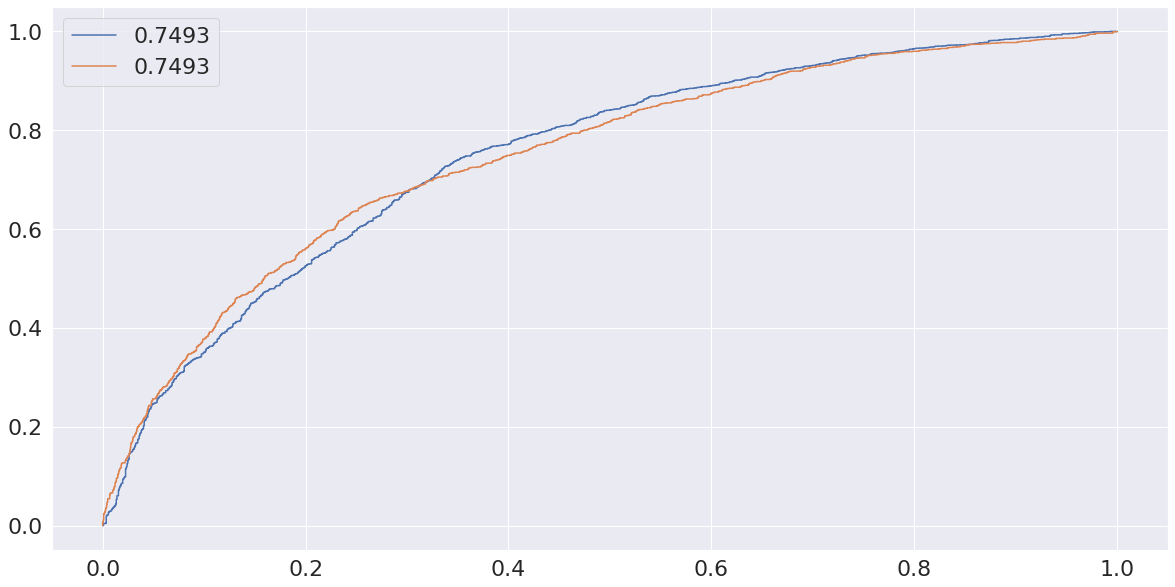

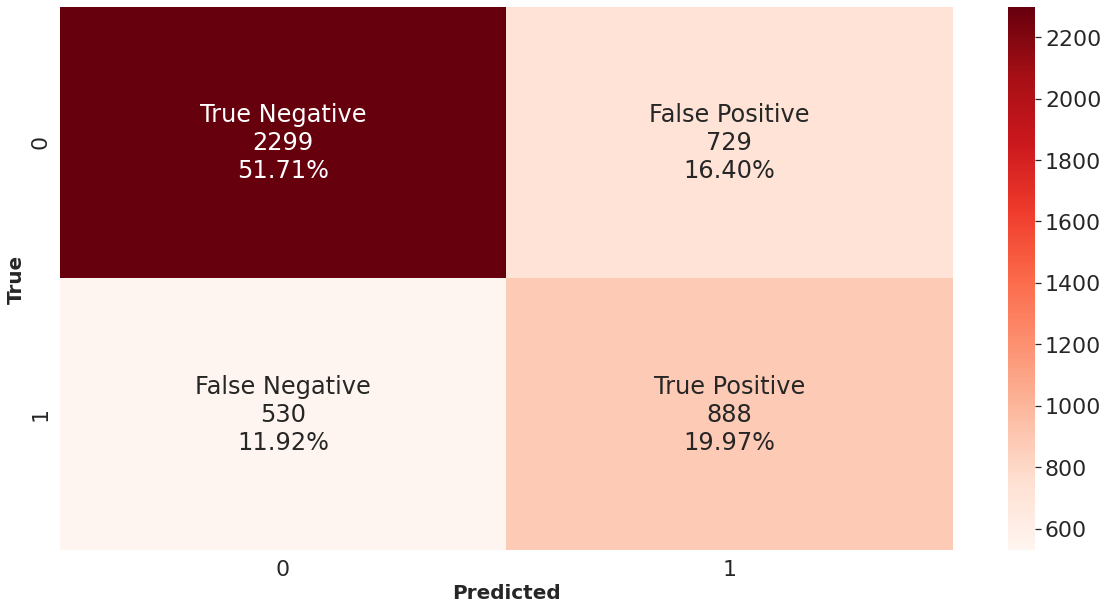

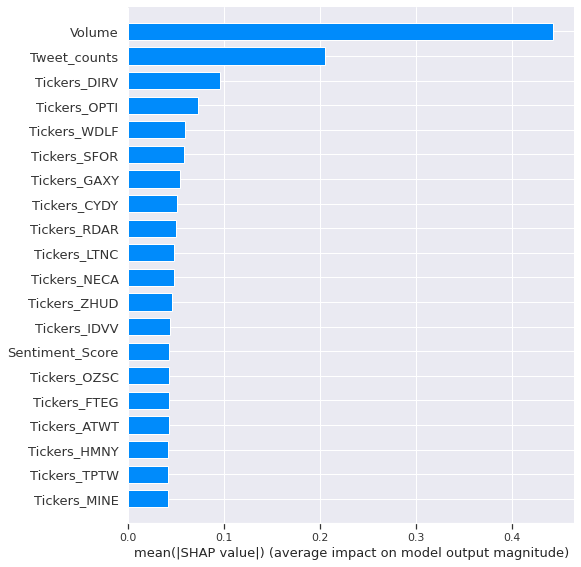

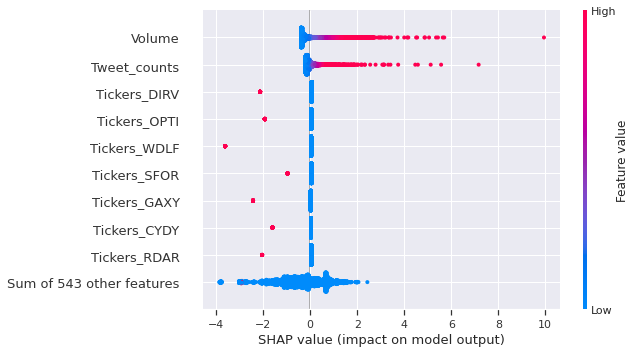

In [33]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
LogisticRegressionCV._get_param_names()
model_lr = LogisticRegression()
lr_params = {'penalty':['elasticnet'],'random_state':[0],'max_iter':[1000],'solver':['saga'],'l1_ratio':[0.1]}
Output_lr = predict_fit(model_lr,6,lr_params,'recall',X_smote,y_smote,X_test,y_test) 
#grid.fit(X_smote, y_smote)
dir(model_lr)
((type(model_lr)).__name__)
Output_lr.keys()
y_pred_lr = Output_lr['model'].predict(X_test)
proba_lr = Output_lr['model'].predict_proba(X_test)
tpr_1_lr, fpr_1_lr, threshold_1_lr = roc_curve(y_test, proba_lr[:,0])
fpr_2_lr, tpr_2_lr, threshold_2_lr = roc_curve(y_test, proba_lr[:,1])
plt.figure(figsize=(20,10))
plt.plot(fpr_1_lr,tpr_1_lr,label=str(round(auc(fpr_1_lr,tpr_1_lr),4)))
plt.plot(fpr_2_lr,tpr_2_lr,label=str(round(auc(fpr_2_lr,tpr_2_lr),4)))
plt.legend(loc='best')
plt.legend(loc='best')
labels = ['True Negative','False Positive','False Negative','True Positive']
cf_matrix = confusion_matrix(y_test,y_pred_lr)
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                    cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(labels,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(20,10))
sns.heatmap(cf_matrix,annot=labels,fmt='',cmap='Reds',cbar=True)
plt.xlabel(r'Predicted',fontsize=20,fontweight='bold')
plt.ylabel(r'True',fontsize=20,fontweight='bold')
plt.show()
explainer = shap.LinearExplainer(Output_lr['model'],X_smote)#, X_train, feature_dependence="independent")
Shap_values = explainer(X_test)
shap.summary_plot(Shap_values, X_smote, plot_type="bar")
shap.plots.beeswarm(Shap_values)

## I will use scikit learn for xgboost classifier

In [34]:
#import sklearn.metrics
#help(sklearn.metrics.confusion_matrix)

In [35]:
(GridSearchCV._get_param_names())

['cv',
 'error_score',
 'estimator',
 'iid',
 'n_jobs',
 'param_grid',
 'pre_dispatch',
 'refit',
 'return_train_score',
 'scoring',
 'verbose']

In [36]:
GridSearchCV.predict_proba

<function sklearn.model_selection._search.BaseSearchCV.predict_proba>

In [37]:
(xgboost.sklearn.XGBClassifier._get_param_names()) ## check the parameters of this classifier 

['base_score',
 'booster',
 'colsample_bylevel',
 'colsample_bynode',
 'colsample_bytree',
 'gamma',
 'learning_rate',
 'max_delta_step',
 'max_depth',
 'min_child_weight',
 'missing',
 'n_estimators',
 'n_jobs',
 'nthread',
 'objective',
 'random_state',
 'reg_alpha',
 'reg_lambda',
 'scale_pos_weight',
 'seed',
 'silent',
 'subsample',
 'verbosity']

Accuracy66.98155645524066


Text(0, 0.5, 'True positive rate')

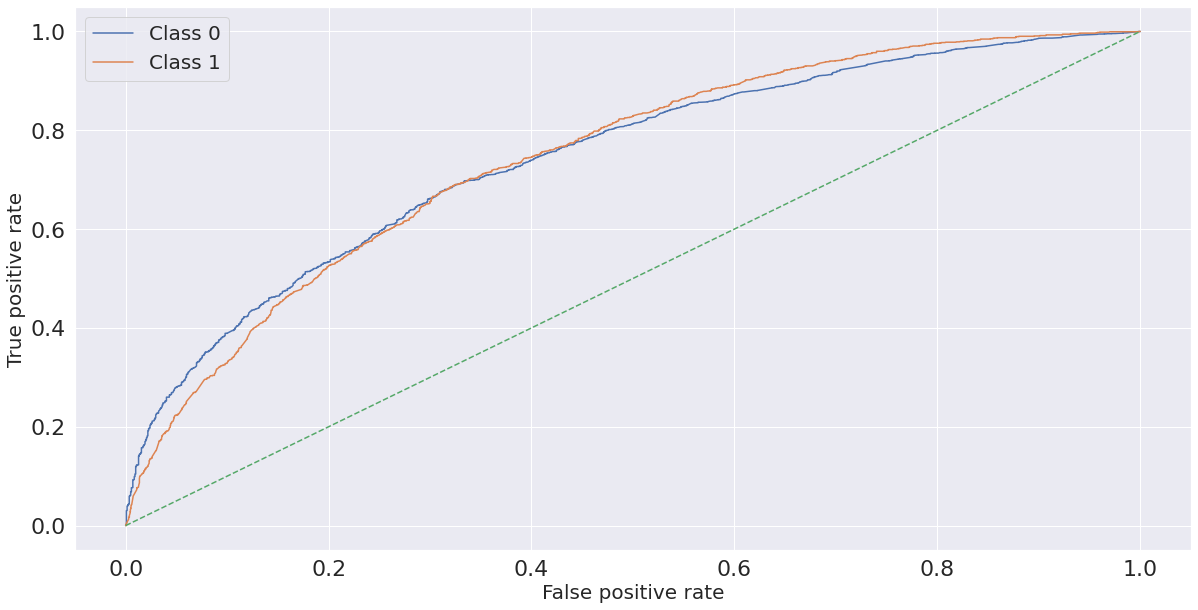

In [38]:
tpr_1, fpr_1, fpr_2, tpr_2, y_pred, model,pipe, precision, recall = XgboostClassifier(X_test,y_test,X_smote,y_smote)
plt.figure(figsize=(20,10))
plt.plot(fpr_1,tpr_1,label='Class 0')
plt.plot(fpr_2,tpr_2,label='Class 1')
plt.legend(loc='best',fontsize=20)
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),'--')
plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)

In [39]:
#X_train.shape
#X_smote.shape

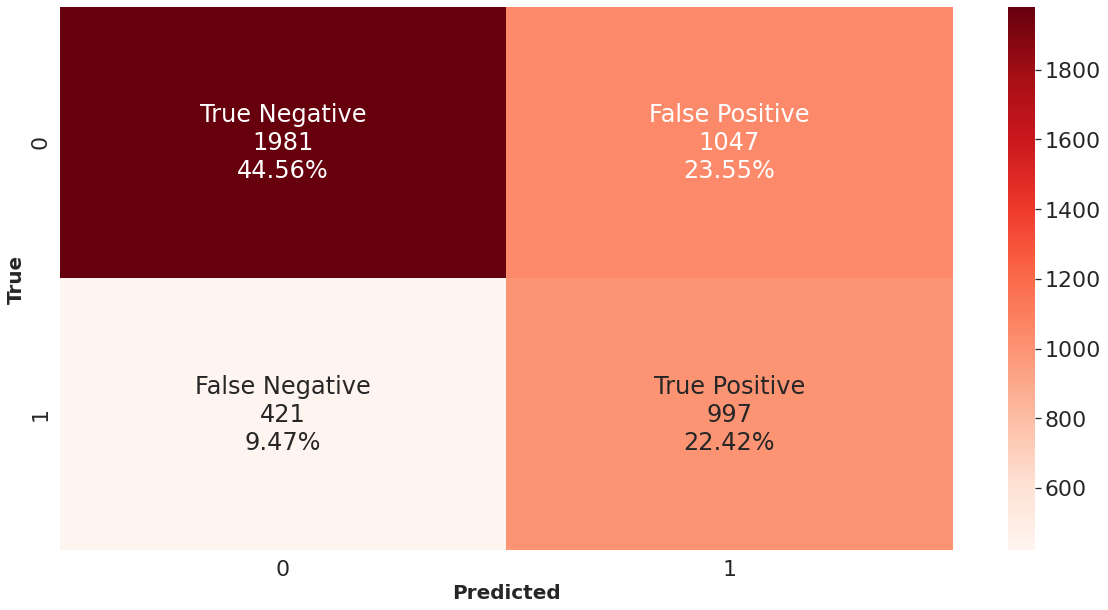

In [40]:



labels = ['True Negative','False Positive','False Negative','True Positive']
cf_matrix = confusion_matrix(y_test,y_pred)
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                    cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(labels,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(20,10))
sns.heatmap(cf_matrix,annot=labels,fmt='',cmap='Reds',cbar=True)
plt.xlabel(r'Predicted',fontsize=20,fontweight='bold')
plt.ylabel(r'True',fontsize=20,fontweight='bold')
plt.show()

## Have to add the numbers here and add the precision and recall curve too for the base classifier.

In [41]:
params = {'learning_rate':[0.1,0.2,0.3],'max_depth':[5,6,7]} ## I am optimizing the XgBoost using the maximum depth and the learning rate. Hyper parameter tuning is an art.

model = xgboost.sklearn.XGBClassifier()

Output = predict_fit(model,6,params,'recall',X_smote,y_smote,X_test,y_test)

In [42]:
Output.keys()

dict_keys(['tpr_1', 'fpr_1', 'fpr_2', 'tpr_2', 'predictions', 'model', 'accuracy', 'precision', 'recall', 'feature_importance'])

(0.0, 1.0)

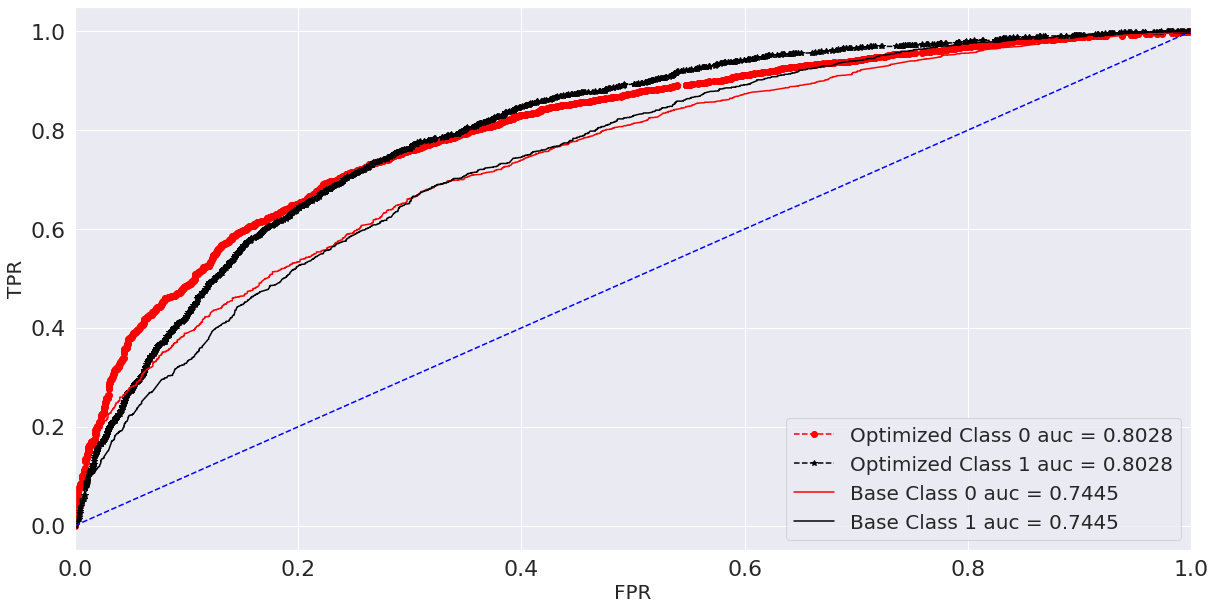

In [43]:
plt.figure(figsize=(20,10))
plt.plot(Output['fpr_1'],Output['tpr_1'],'--o',label='Optimized Class 0'+' '+'auc = '+str(round(auc(Output['fpr_1'],Output['tpr_1']),4)),color='red')
plt.plot(Output['fpr_2'],Output['tpr_2'],'--*',label='Optimized Class 1'+' '+'auc = '+str(round(auc(Output['fpr_2'],Output['tpr_2']),4)),color='black')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),'--',color='blue')
plt.plot(fpr_1,tpr_1,label='Base Class 0'+' '+'auc = '+str(round(auc(fpr_1,tpr_1),4)),color='red')
plt.plot(fpr_2,tpr_2,label='Base Class 1'+' '+'auc = '+str(round(auc(fpr_2,tpr_2),4)),color='black')
plt.legend(loc='best',fontsize=20)
plt.xlabel('FPR',fontsize=20)
plt.ylabel('TPR',fontsize=20)
plt.xlim(0,1)


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

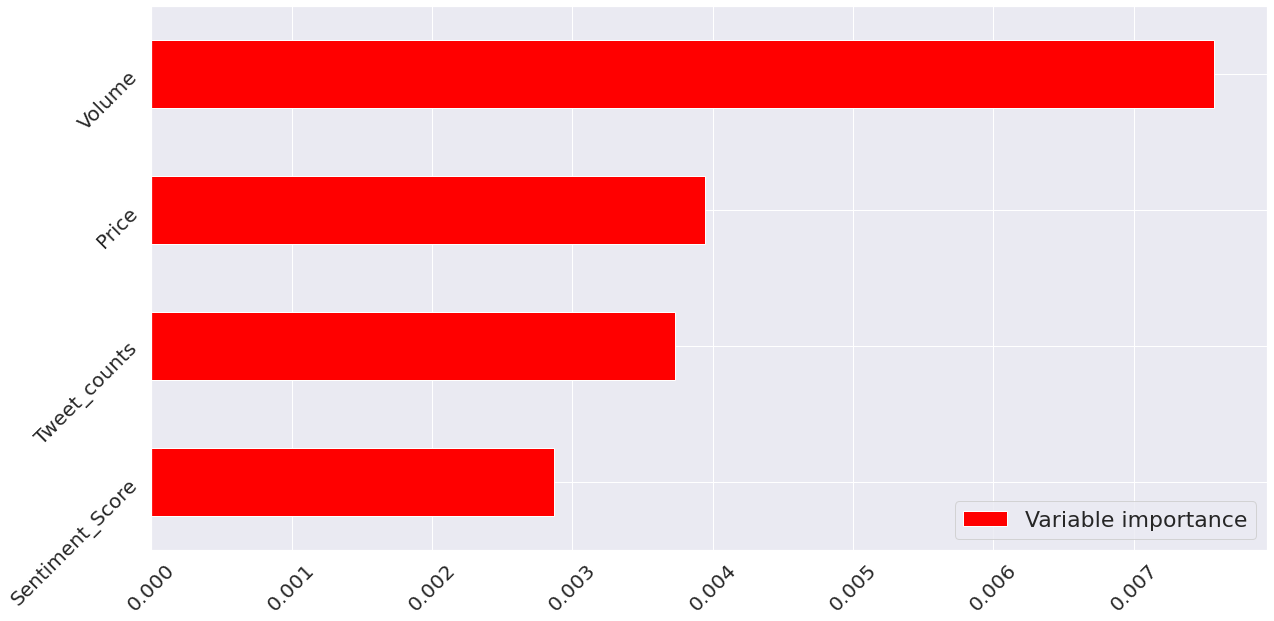

In [44]:

feature_names = list(df_xgboost.columns)

feature_names.remove('Indicator')

forest_importances = pd.DataFrame((Output['model']).feature_importances_, index=feature_names).rename(columns={0:'Variable importance'})
forest_importances[0:4].sort_values(by='Variable importance').plot(kind='barh',rot=0,color='red',figsize=(20,10))
plt.legend(loc='best')
plt.xticks(rotation=45,fontsize=20)
plt.yticks(rotation=45,fontsize=20)

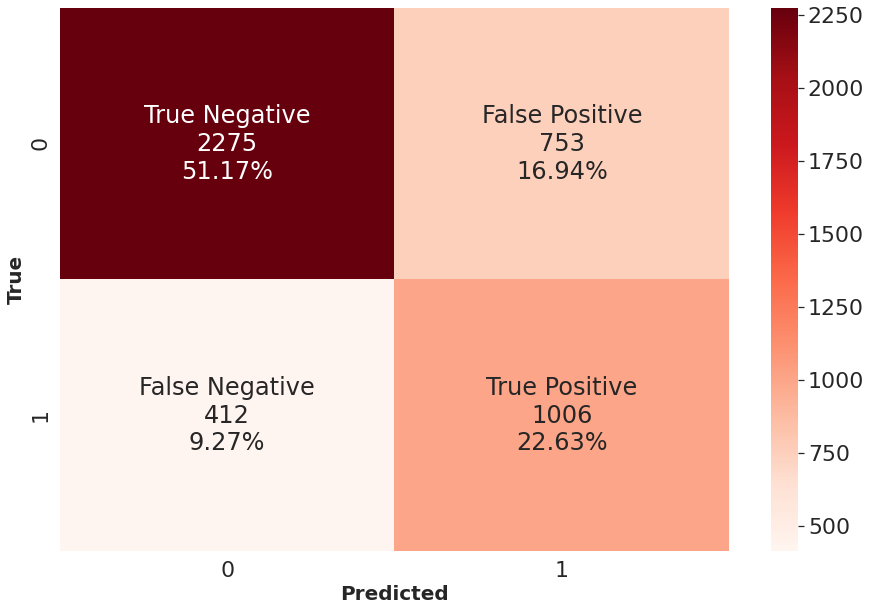

In [45]:


labels = ['True Negative','False Positive','False Negative','True Positive']
cf_matrix = confusion_matrix(y_test,Output['predictions'])
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                    cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(labels,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(15,10))
sns.heatmap(cf_matrix,annot=labels,fmt='',cmap='Reds',cbar=True)
plt.xlabel(r'Predicted',fontsize=20,fontweight='bold')
plt.ylabel(r'True',fontsize=20,fontweight='bold')
plt.show()


In [46]:

explainer = shap.Explainer(Output['model'])
shap_values = explainer(X_smote)

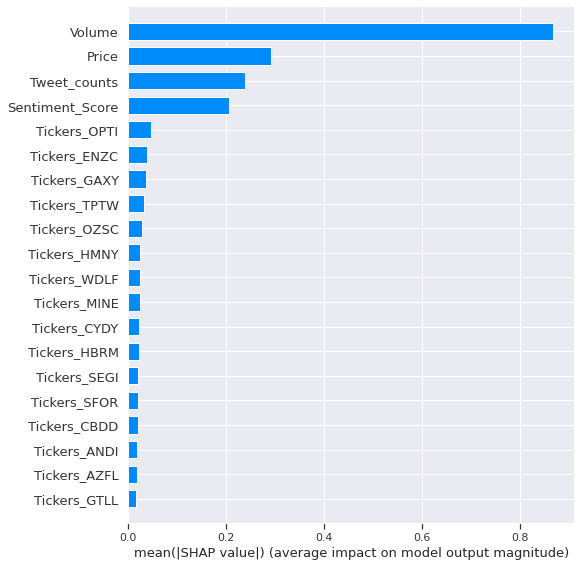

In [47]:
plt.figure(figsize=(20,10))
shap.summary_plot(shap_values, X_smote, plot_type="bar")

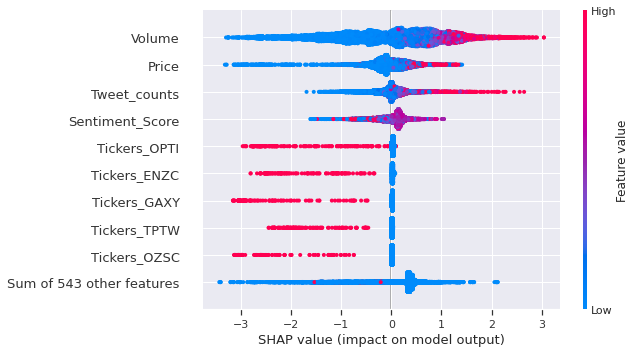

In [48]:
plt.figure(figsize=(20,10))
shap.plots.beeswarm(shap_values)

## For the relatively optimized XgBoost model SHAP values indicates that the trade volume feature has the highest positive impact in the model output--i.e. in classifying the pumped stock. This is followed by stock price, tweet counts and the sentiment score. Therefore, the hypothesis I made that the sentiment score contributes towards the pump and dump scheme seems to be relatively true as it was given a higher weight at least by two models.

## Optimization results in a better True positive classification